In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, autograd as ag
from tqdm import tqdm
from typing import Union
from copy import deepcopy

In [2]:
hyperparams = {
        'n_tasks': 1000,
        'n_episode': 150,
        'n_timesteps': 10,
        'input_dim': 2,
        'hidden_dim': 512,
        'output_dim': 2,
        'lr': 1e-4,
        'batch_size': 128,
        'n_epochs': 100,
        }

# Data Simulation

In [3]:
class TrainingDataset(Dataset):
	# `set_seed=None` means no seed fixed.  
	def __init__(self, n_tasks=hyperparams['n_tasks'], n_episode=hyperparams['n_episode'], 
				n_timesteps=hyperparams['n_timesteps'], set_seed: Union[int, None]=None):
		super().__init__()
		self.q = []
		self.x = []
		self.z = []
		if set_seed is not None:
			np.random.seed(set_seed)
		l_of_tasks = np.random.normal(loc=1, scale=0.3, size=(n_tasks,2))
		for i in tqdm(range(n_tasks)):
			l = l_of_tasks[i]
			for _ in range(n_episode):
				q_, x, z = TrainingDataset.generate_episode(l, n_timesteps)
				self.q.extend(q_)
				self.x.extend(x)
				self.z.extend(z)
		self.q = np.stack(self.q, axis=1).reshape(-1,2)
		self.x = np.stack(self.x, axis=1).reshape(-1,2)
		self.z = np.stack(self.z, axis=1).reshape(-1,2)
		assert self.q.shape == self.x.shape
		print("Two Arm Link Dataset Generation Finished!")
		
	def __getitem__(self, index):
		q = self.q[index]
		x = self.x[index]
		z = self.z[index]
		sample = {
			"angle": torch.tensor(q),
			"true_pos": torch.tensor(x),
			"noisy_pos": torch.tensor(z),
		}
		return sample

	def __len__(self):
		return len(self.q)

	@staticmethod
	def generate_episode(l, n_timesteps):
		def x_of_q(q, l):
			# q: array (2,) containing the two angles
			# l: array (2,) containing the limb lengths 
			x = l[0] * np.cos(q[0]) + l[1] * np.cos(q[0] + q[1])
			y = l[0] * np.sin(q[0]) + l[1] * np.sin(q[0] + q[1])
			return np.array([x, y])

		q_0 = np.random.uniform(low= -np.pi, high= np.pi, size=(2,1))
		u = np.random.randn(2, n_timesteps-1)
		q = u.cumsum(axis=1) + q_0
		q = np.concatenate((q_0, q), axis=1)
		x = x_of_q(q, l=l)
		z = x + np.random.normal(0, scale=0.001, size=(2, n_timesteps))
		assert q.shape == x.shape
		return q, x, z

In [4]:
def get_loader(batch_size=hyperparams['batch_size'], n_tasks=hyperparams['n_tasks'], 
                set_seed: Union[int, None]=None, shuffle: bool=True):
    dataset = TrainingDataset(n_tasks=n_tasks, set_seed=set_seed)
    data_loader = DataLoader(dataset=dataset,
                            batch_size=batch_size,
                            shuffle=shuffle,
                            pin_memory=True,
                            drop_last=True,
                            )
    return data_loader

# Build model

In [5]:
class DropoutLayer(nn.Module):
    def __init__(self, hidden_dim=hyperparams['hidden_dim']):
        super(DropoutLayer, self).__init__()
        self.mask = torch.ones(hidden_dim, dtype=torch.float32, requires_grad=False)
        self.training = False

    def forward(self, x):
        return x * self.mask

    def update(self, mask: np.ndarray):
        assert mask.shape == self.mask.shape, f"new mask shape should be {self.mask.shape} but giving {mask.shape}"
        self.mask = torch.Tensor(mask)
        
    def get(self):
        return self.mask.numpy()

In [6]:
class MyModel(nn.Module):
    def __init__(self, input_dim=hyperparams['input_dim'], hidden_dim=hyperparams['hidden_dim'], 
                output_dim=hyperparams['output_dim']):
        super().__init__()
        self.lin1 = nn.Linear(in_features=input_dim, out_features=hidden_dim)
        self.lin2 = nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
        self.lin3 = nn.Linear(in_features=hidden_dim, out_features=output_dim)
        self.relu = nn.ReLU()
        # dropout for pretraining and finetunning
        self.dropout_for_GD = nn.Dropout(p=0.5)
        # dropout for smc
        self.dropout = DropoutLayer(hidden_dim=hidden_dim)

    def forward(self, x):
        x = self.lin1(x)
        x = self.relu(x)
        x = self.lin2(x)
        x = self.relu(x)
        if self.training:
            x = self.dropout_for_GD(x)
        else:
            x = self.dropout(x)
        x = self.lin3(x)
        return x
        
    def update_dropout_mask(self, mask: np.ndarray):
        self.dropout.update(mask)

    def get_dropout_mask(self):
        return self.dropout.get()

# Multi-Task Training

In [14]:
train_loader = get_loader(n_tasks=1000, set_seed=0, shuffle=True)

100%|██████████| 1000/1000 [00:05<00:00, 178.48it/s]


Two Arm Link Dataset Generation Finished!


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MyModel().to(device)
model = model.double()
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=hyperparams['lr'])
criterion = nn.MSELoss()

In [16]:
def train_multi_task(data_loader=train_loader, nb_epochs=hyperparams['n_epochs']):
    total_loss = []
    for epoch in range(1, nb_epochs + 1):
    	# store the loss in each batch
        losses = []
        # use tqdm to better visualize the training process
        with tqdm(data_loader, unit="batch") as tepoch: # evaluate every batch
            for data in tepoch:
                tepoch.set_description(f"Epoch {epoch}") # custome the printed message in tqdm
                x = data['angle'].to(device)
                y = data['true_pos'].to(device)
                optimizer.zero_grad()
                output = model.forward(x)
                loss = criterion(output, y)
                loss.backward() # backward propagation
                optimizer.step() # update parameters
                losses.append(loss.item())
                # custome what is printed in tqdm message
                tepoch.set_postfix(loss=sum(losses)/len(losses))
        total_loss.append(sum(losses)/len(losses))
    return total_loss

In [ ]:
total_loss = train_multi_task() # return a list of loss in different epochs

Epoch 99:  74%|███████▎  | 8618/11718 [00:59<00:21, 142.36batch/s, loss=0.113]]

In [ ]:
# plt.plot(total_loss)

In [ ]:
# save parameters and optimizer
torch.save({
    'state_dict': model.state_dict(),
    'loss': total_loss,
    'optimizer' : optimizer.state_dict(),
}, 'Task1_multiTask.pth.tar')

# Reptile Training

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_reptile = MyModel().to(device)
model_reptile = model_reptile.double()
model_reptile.train()
optimizer_reptile = torch.optim.Adam(model_reptile.parameters(), lr=hyperparams['lr'])
criterion = nn.MSELoss()

In [8]:
train_dataset_reptile = TrainingDataset(n_tasks=hyperparams['n_tasks'], set_seed=0)

100%|██████████| 1000/1000 [00:05<00:00, 174.89it/s]


Two Arm Link Dataset Generation Finished!


In [9]:
seed = 0
rng = np.random.RandomState(seed)
torch.manual_seed(seed)

In [10]:
def train_reptile(dataset=train_dataset_reptile, nb_epochs=hyperparams['n_epochs']):
    def totorch(x):
        return ag.Variable(torch.DoubleTensor(x).to(device))
        
    def train_on_batch(x, y):
        x = totorch(x)
        y = totorch(y)
        optimizer_reptile.zero_grad()
        ypred = model_reptile.forward(x)
        loss = criterion(ypred, y)
        loss.backward()
        optimizer_reptile.step()
        return loss

    batch_size = hyperparams['batch_size']
    meta_step_size = 0.02
    n_episode = hyperparams['n_episode']
    n_task = hyperparams['n_tasks']
    n_timestep = hyperparams['n_timesteps']
    history = []
    for epoch in range(nb_epochs):
        losses = []
        for meta_iter in range(n_task):
            x_train = dataset.q[meta_iter*n_episode*n_timestep:(meta_iter+1)*n_episode*n_timestep]
            y_train = dataset.x[meta_iter*n_episode*n_timestep:(meta_iter+1)*n_episode*n_timestep]

            weights_before = deepcopy(model_reptile.state_dict())
            inds = rng.permutation(len(x_train))
            for start in range(0, len(x_train), batch_size):
                mbinds = inds[start:start+batch_size]
                losses.append(train_on_batch(x_train[mbinds], y_train[mbinds]))
            # Interpolate between current weights and trained weights from this task
            # I.e. (weights_before - weights_after) is the meta-gradient
            weights_after = model_reptile.state_dict()
            outerstepsize = meta_step_size * (1 - meta_iter / n_task) # linear schedule
            model_reptile.load_state_dict({name: 
                weights_before[name] + (weights_after[name] - weights_before[name]) * outerstepsize 
                for name in weights_before})

        loss = sum(losses) / len(losses)
        print(f"Epoch: {epoch}, Loss: {loss.item()}")
        history.append(loss.item())
    return history

In [11]:
loss_reptile = train_reptile()

Epoch: 0, Loss: 0.7845256581270913
Epoch: 1, Loss: 0.5822564673916465
Epoch: 2, Loss: 0.4726917451793204
Epoch: 3, Loss: 0.41711226131716816
Epoch: 4, Loss: 0.38486938876607285
Epoch: 5, Loss: 0.3640564027237242
Epoch: 6, Loss: 0.348497459499168
Epoch: 7, Loss: 0.33627063155620895
Epoch: 8, Loss: 0.32576507810596383
Epoch: 9, Loss: 0.31709687629566696
Epoch: 10, Loss: 0.3090205492594535
Epoch: 11, Loss: 0.30194097110001256
Epoch: 12, Loss: 0.29582357585739427
Epoch: 13, Loss: 0.2900954158014786
Epoch: 14, Loss: 0.2849028316589086
Epoch: 15, Loss: 0.28010659766977575
Epoch: 16, Loss: 0.27572265218202324
Epoch: 17, Loss: 0.27187908040273306
Epoch: 18, Loss: 0.267788477910274
Epoch: 19, Loss: 0.264464613131871
Epoch: 20, Loss: 0.26106344826920247
Epoch: 21, Loss: 0.25799031431227487
Epoch: 22, Loss: 0.2551453216676167
Epoch: 23, Loss: 0.25215530547453174
Epoch: 24, Loss: 0.24905643754944815
Epoch: 25, Loss: 0.24674231229377444
Epoch: 26, Loss: 0.2443834361490857
Epoch: 27, Loss: 0.2419928

In [13]:
# save parameters and optimizer
torch.save({
    'state_dict': model_reptile.state_dict(),
    'loss': loss_reptile,
    'optimizer' : optimizer_reptile.state_dict(),
}, 'Task1_reptile.pth.tar')

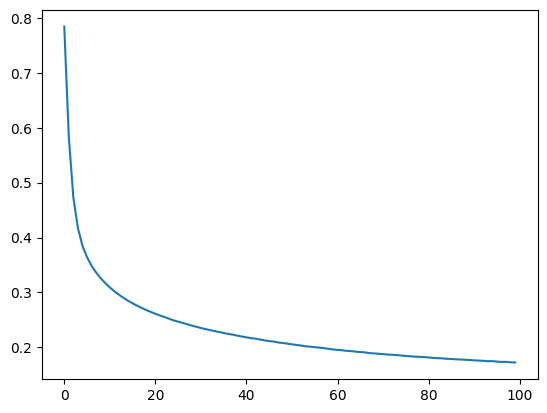

In [12]:
plt.plot(loss_reptile)

# Load model

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MyModel().to(device)
checkpoint = torch.load('Task1_multiTask.pth.tar')
model.load_state_dict(checkpoint['state_dict'])
model.eval()

MyModel(
  (lin1): Linear(in_features=2, out_features=512, bias=True)
  (lin2): Linear(in_features=512, out_features=512, bias=True)
  (lin3): Linear(in_features=512, out_features=2, bias=True)
  (relu): ReLU()
  (dropout_for_GD): Dropout(p=0.5, inplace=False)
  (dropout): DropoutLayer()
)

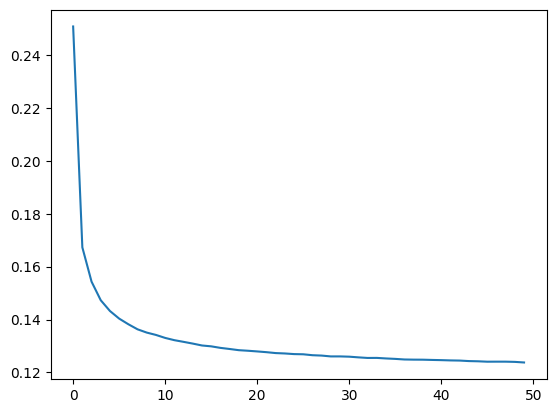

In [8]:
l = checkpoint['loss']
plt.plot(l)